# Problema de clasificación con TensorFlow/Keras - Red Convolucional

## Autores: Mauricio Beltrán, Pablo Sánchez, Alfonoso Carabantes y Juan Antonio Grande

Se plantea determinar si una persona gana más de 50,000 dólares al año a partir de las siguientes variables:

- age: Variable continua que representa la edad del individuo.
- workclass: Variable categórica que representa el tipo de clase laboral a la que pertenece el individuo. Los posibles valores incluyen Privado, Trabajador autónomo (no incorporado), Trabajador autónomo (incorporado), Gobierno federal, Gobierno local, Gobierno estatal, Sin paga, Nunca trabajó.
- fnlwgt: Variable continua que representa el peso final de la población, utilizado en el muestreo.
- education: Variable categórica que representa el nivel más alto de educación alcanzado por el individuo. Los posibles valores incluyen varios niveles de educación desde Preescolar hasta Doctorado.
- education-num: Variable continua que representa la codificación numérica de la educación (una representación alternativa de la característica 'education').
- marital-status: Variable categórica que representa el estado civil del individuo. Los posibles valores incluyen Casado (cónyuge civil), Divorciado, Soltero, Separado, Viudo, Casado (cónyuge ausente), Casado con Fuerzas Armadas.
- occupation: Variable categórica que representa la ocupación del individuo. Los posibles valores incluyen diversas categorías laborales como Soporte técnico, Ventas, Ejecutivo/Gerencial, Agricultura/Pesca, etc.
- relationship: Variable categórica que representa la relación del individuo con el hogar. Los posibles valores incluyen Esposa, Hijo propio, Esposo, No pertenece a la familia, Pariente, Soltero.
- race: Variable categórica que representa la raza del individuo. Los posibles valores incluyen Blanco, Asiático-isleño del Pacífico, Indígena americano-Eskimal, Negro, Otro.
- sex: Variable categórica que representa el género del individuo. Los posibles valores son Mujer y Hombre.
- capital-gain: Variable continua que representa las ganancias de capital del individuo.
- capital-loss: Variable continua que representa las pérdidas de capital del individuo.
- hours-per-week: Variable continua que representa el número de horas trabajadas por semana por el individuo.
- native-country: Variable categórica que representa el país de origen del individuo. Los posibles valores incluyen varios países como Estados Unidos, India, Japón, México, etc.

Se puede descargar los datos en: https://archive.ics.uci.edu/dataset/2/adult

## Importar datos y librerías de trabajo

In [102]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)
from numpy.random import seed
seed(123)

from tensorflow import random
random.set_seed(2)

Se leen los datos. Y un pequeño resumen de las variables numéricas:

In [103]:
datos=pd.read_csv('../data/adult_data.csv').drop(columns=["x"])

datos = datos.drop(columns=["fnlwgt", "educational-num"])

datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   education       48842 non-null  object
 3   marital-status  48842 non-null  object
 4   occupation      48842 non-null  object
 5   relationship    48842 non-null  object
 6   race            48842 non-null  object
 7   gender          48842 non-null  object
 8   capital-gain    48842 non-null  int64 
 9   capital-loss    48842 non-null  int64 
 10  hours-per-week  48842 non-null  int64 
 11  native-country  48842 non-null  object
 12  income          48842 non-null  object
dtypes: int64(4), object(9)
memory usage: 4.8+ MB


In [104]:
# Breve explicación del dataset
print('Tamaño:', datos.shape)  # 284.807 registros y 31 variables

datos.describe()  #summary de las variables (30 variables explicativas y target: Class)

Tamaño: (48842, 13)


,age,capital-gain,capital-loss,hours-per-week
count,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1079.067626,87.502314,40.422382
std,13.710510,7452.019058,403.004552,12.391444
min,17.000000,0.000000,0.000000,1.000000
25%,28.000000,0.000000,0.000000,40.000000
50%,37.000000,0.000000,0.000000,40.000000
75%,48.000000,0.000000,0.000000,45.000000
max,90.000000,99999.000000,4356.000000,99.000000


## Agrupación de niveles de las variables categóricas

`workclass`

In [105]:
cond = [datos["workclass"].isin(["Self-emp-not-inc", "Self-emp-inc"]),
        datos["workclass"].isin(["State-gov", "Local-gov", "Federal-gov"]),
        datos["workclass"].isin(["?", "Without-pay", "Never-worked"])]
values = ["Self", "State", "Other"]

datos["workclass"] = np.select(cond, values, default=datos["workclass"])
datos["workclass"] = datos["workclass"].astype("category")

`education`

In [106]:
cond = [datos["education"].isin(["Assoc-acdm", "Assoc-voc"]),
        datos["education"].isin(["Preschool", "HS-grad"]),
        datos["education"].isin(["Bachelors", "Masters", "Doctorate", "Some-college"]),
        datos["education"] == "Prof-school"]
values = ["Associate", "School", "BCMD", "Prof-school"]

datos["education"] = np.select(cond, values, default="Xth")
datos["education"] = datos["education"].astype("category")

`marital-status`

In [107]:
cond = [datos["marital-status"].isin(["Separated", "Divorced"]),
        datos["marital-status"].isin(["Married-civ-spouse", "Married-spouse-absent", "Married-AF-spouse"]),
        datos["marital-status"] == "Widowed"]
values = ["Divorced/Separated", "Married", "Widowed"]

datos["marital-status"] = np.select(cond, values, default="Never-married")
datos["marital-status"] = datos["marital-status"].astype("category")

`occupation`

In [108]:
values = ["Protective-serv", "Craft-repair", "Exec-managerial", "Adm-clerical", "Sales", "Machine-op-inspct"]
datos["occupation"] = np.where(datos["occupation"].isin(values), datos["occupation"], "Other")
datos["occupation"] = datos["occupation"].astype("category")

In [109]:
datos["occupation"].unique()

['Machine-op-inspct', 'Other', 'Protective-serv', 'Craft-repair', 'Adm-clerical', 'Exec-managerial', 'Sales']
Categories (7, object): ['Adm-clerical', 'Craft-repair', 'Exec-managerial', 'Machine-op-inspct', 'Other', 'Protective-serv', 'Sales']

In [170]:
datos[datos["income"] == 1].head(1)

,age,workclass,education,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
2,28,State,Associate,Married,Protective-serv,Husband,White,Male,0,0,40,United-States,1


## Análisis descriptivo y preprocesado de datos

`Distribución del Target`

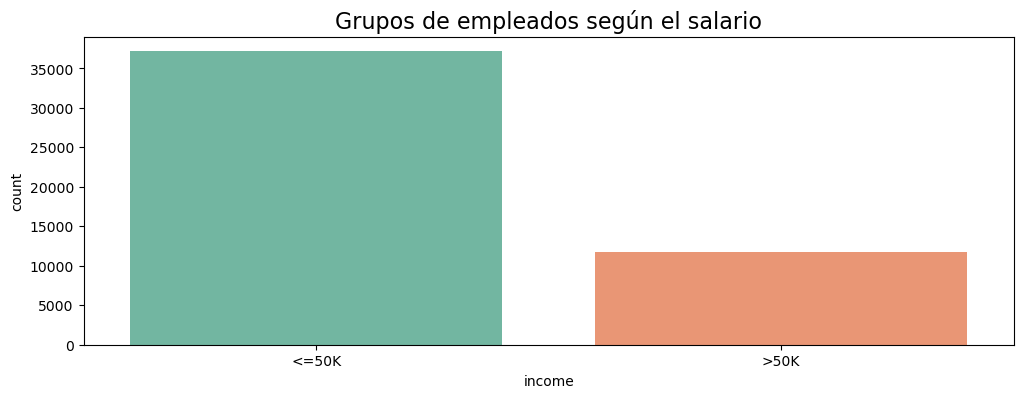

In [111]:
plt.figure(figsize=(12, 4)) # tamaño del gráfico
sns.countplot(x='income', data=datos, palette='Set2')
plt.title('Grupos de empleados según el salario', fontsize=16)
plt.show()

datos["income"].value_counts(normalize=True)

datos["income"] = np.where(datos["income"] == ">50K", 1, 0)

`Correlación variables numéricas`

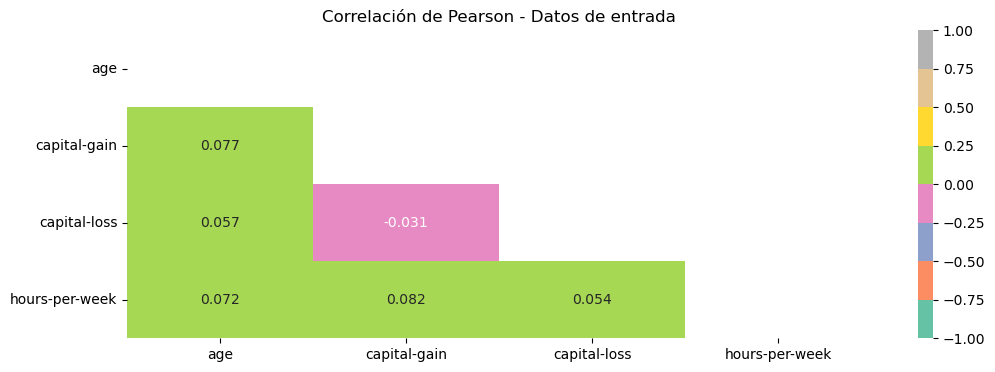

In [112]:
# nombre de las columnas de interés
columnas_corr = list(datos.select_dtypes(exclude=['category', 'object']).columns)
corr_list = columnas_corr.copy()
corr_list.remove("income")

# Análisis de correlación de las variables explicativas
matriz_cor=datos[corr_list].corr('pearson')  #correlación de pearson

# como cor(x,x)=1 y cor(x,y)=cor(y,x) se puede disponer solo de la diagonal inferior.
# La siguiente función elimina la parte superior de la matriz de correlaciones
mask = np.zeros(matriz_cor.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True

plt.figure(figsize=(12, 4)) # tamaño del gráfico

sns.heatmap(matriz_cor, annot = True, vmin = -1, vmax = 1, cmap = 'Set2', mask=mask)
# cmap para elegir la gama de colores y vmin y vmax identificar todo el espectro de valores de la correlación de pearson [-1,1]
plt.title('Correlación de Pearson - Datos de entrada', fontsize=12)
plt.show()

Vemos que no hay correlación lineal entre las variables explicativas

## Definición de la muestra: entrenamiento y validación

In [144]:
# Partición de la muestra
TEST_SIZE = 0.25 #muestra para el test
RANDOM_SEED = 123 
X_train, X_test, y_train, y_test = train_test_split(datos.drop(columns=["income"]),
                                                    datos["income"],
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_SEED,
                                                    stratify=datos["income"]) # división estratificada

print(f"Tamaño train: {X_train.shape}")
print(f"Tamaño validación: {X_test.shape}")

Tamaño train: (36631, 12)
Tamaño validación: (12211, 12)


Se convierten a variables dummy las no numéricas

In [136]:
category_columns = list(datos.select_dtypes(include=['category', 'object']).columns)

X_train_dummy = pd.get_dummies(X_train[category_columns], drop_first=True, dtype=float)
X_test_dummy = pd.get_dummies(X_test[category_columns], drop_first=True, dtype=float)

Obtenemos las variables numéricas y concatenamos:

In [138]:
X_train_num = X_train[corr_list]
X_test_num = X_test[corr_list]

X_train = pd.concat([X_train_num, X_train_dummy], axis=1) # se añaden a nivel registro
X_test = pd.concat([X_test_num, X_test_dummy], axis=1)

Al trabajar con variables categóricas puede ser que algún nivel de los datos de entrenamiento no esté en nuestros datos de validación.

In [139]:
True if len(X_train.columns) == len(X_test.columns) else False

False

Puede verse que existe tal discrepancia. Se analizan las variables que no existen para rellenarlas a cero.

In [140]:
add_col_test = [col for col in X_train.columns if col not in X_test.columns]
add_col_test

['native-country_Holand-Netherlands']

In [141]:
for col in add_col_test:
    X_test[col] = 0 # se incluye con valor a cero

X_test = X_test[X_train.columns] # la muestra de test con el mismo orden que la muestra de entrenamiento

In [142]:
True if len(X_train.columns) == len(X_test.columns) else False

True

In [167]:
datos["hours-per-week"].max()

99

Una vez tenemos los datos de entrada adecuadamente formulados, se normalizan los datos:

In [121]:
# Normalización muestra entrenamiento y test

# conversión a vector numpy la serie de pandas
y_train=np.array(y_train)
y_test=np.array(y_test)

# Los datos son normalizados (min=0, máx=1) para un buen entendimiento de la red neuronal
norm = MinMaxScaler()
X_train = norm.fit_transform(X_train)
X_test = norm.transform(X_test)

In [122]:
# detalle del tamaño de los datos de entrada
print('Tamaño datos (train):', X_train.shape)
print('Tamaño datos (test):', X_test.shape)

Tamaño datos (train): (36631, 71)
Tamaño datos (test): (12211, 71)


## Modelización usando redes convolucionales

In [123]:
# Cambio de tamaño de los datos de entrada -> uso de la función reshape
# En este caso, en vez de aplanar los datos, se expanden (se añade una nueva dimensión -> canal)

# Nuevo datamaño del dataset (incluímos una versió )
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('Tamaño datos entrada a la red:', X_train.shape) # ejemplo

Tamaño datos entrada a la red: (36631, 71, 1)


### Arquitectura de la red convolucional (2 capas convolucionales + 2 capas densas)

In [124]:
#  Creación de la arquitectura

model = Sequential()

# 1º capa de convolución
model.add(Conv1D(filters=32,  # número de filtros
                 kernel_size=2,
                 strides=1,
                 activation='relu', # función de activación rectificadro unitario
                 input_shape=X_train[0].shape))  # 30 variables + la profundidad

model.add(BatchNormalization()) # normalización por bloques
model.add(MaxPooling1D()) # capa de maxpooling

# 2º capa de convolución (doble de filtros que la inicial)
model.add(Conv1D(filters=64,
                 kernel_size=2,
                 strides=1,
                 activation='relu'))

model.add(BatchNormalization())
model.add(Dropout(0.3)) # capa de dropout
model.add(MaxPooling1D()) # capa de maxpooling

model.add(Flatten()) # aplanamiento de los datos para pasar a la red neuronal densamente conectada
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3)) # capa de dropout - para evitar sobreajuste del modelo
model.add(Dense(1, activation='sigmoid')) # función de activación de la capa de salida: función sigmoide (target binario)

Una vez definida la arquitectura podemos ver el número de parámetros por cada capa de la red neuronal

In [125]:
model.summary() # Summary de la arquitectura creada

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 70, 32)            96        
                                                                 
 batch_normalization_4 (Bat  (None, 70, 32)            128       
 chNormalization)                                                
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 35, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 34, 64)            4160      
                                                                 
 batch_normalization_5 (Bat  (None, 34, 64)            256       
 chNormalization)                                                
                                                      

Se realiza el proceso de aprendizaje de la red

In [126]:
# Compilaciónd del modelo

lr = 0.001 # tasa de aprendizaje

# Función de pérdida: binary crossentropy (problema de clasificación binaria)
# Optimizador para calcular los pesos de la red (ADAM - proceso del gradiente descendiente más utilizado en deep learning)
model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
epochs = 30 # número de veces que se entrena el modelo
muestra_val = 0.15 # parte de la muestra se divide para tener un proceso de validación en el entrenamiento
history=model.fit(X_train,
                  y_train,
                  epochs=epochs,
                  validation_split=muestra_val,
                  verbose=1)

Epoch 1/30
973/973 [==============================] - 11s 8ms/step - loss: 0.4054 - accuracy: 0.8070 - val_loss: 0.3509 - val_accuracy: 0.8278
Epoch 2/30
973/973 [==============================] - 7s 7ms/step - loss: 0.3729 - accuracy: 0.8246 - val_loss: 0.3385 - val_accuracy: 0.8377
Epoch 3/30
973/973 [==============================] - 6s 6ms/step - loss: 0.3621 - accuracy: 0.8294 - val_loss: 0.3324 - val_accuracy: 0.8409
Epoch 4/30
973/973 [==============================] - 6s 6ms/step - loss: 0.3569 - accuracy: 0.8302 - val_loss: 0.3298 - val_accuracy: 0.8415
Epoch 5/30
973/973 [==============================] - 6s 7ms/step - loss: 0.3526 - accuracy: 0.8330 - val_loss: 0.3505 - val_accuracy: 0.8280
Epoch 6/30
973/973 [==============================] - 8s 8ms/step - loss: 0.3455 - accuracy: 0.8360 - val_loss: 0.3352 - val_accuracy: 0.8426
Epoch 7/30
973/973 [==============================] - 6s 6ms/step - loss: 0.3425 - accuracy: 0.8367 - val_loss: 0.3205 - val_accuracy: 0.8479
Epoch

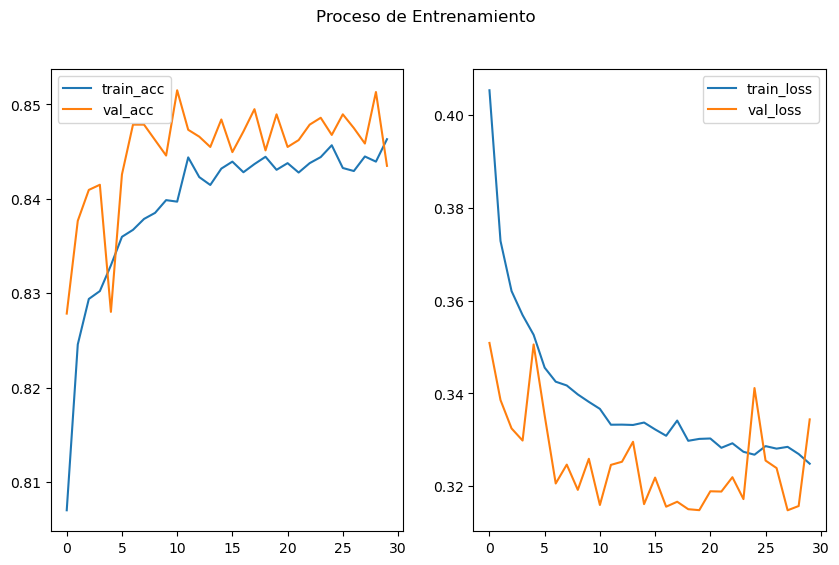

In [127]:
# Visualización del proceso de validación
df_train=pd.DataFrame(history.history)
df_train['epochs']=history.epoch

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

fig.suptitle('Proceso de Entrenamiento', fontsize=12)

ax1.plot(df_train['epochs'], df_train['accuracy'], label='train_acc')
ax1.plot(df_train['epochs'], df_train['val_accuracy'], label='val_acc')

ax2.plot(df_train['epochs'], df_train['loss'], label='train_loss')
ax2.plot(df_train['epochs'], df_train['val_loss'], label='val_loss')

ax1.legend(loc='best')
ax2.legend(loc='best')
plt.show()

In [151]:
norm.feature_names_in_

array(['age', 'capital-gain', 'capital-loss', 'hours-per-week',
       'workclass_Private', 'workclass_Self', 'workclass_State',
       'education_BCMD', 'education_Prof-school', 'education_School',
       'education_Xth', 'marital-status_Married',
       'marital-status_Never-married', 'marital-status_Widowed',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Machine-op-inspct', 'occupation_Other',
       'occupation_Protective-serv', 'occupation_Sales',
       'relationship_Not-in-family', 'relationship_Other-relative',
       'relationship_Own-child', 'relationship_Unmarried',
       'relationship_Wife', 'race_Asian-Pac-Islander', 'race_Black',
       'race_Other', 'race_White', 'gender_Male',
       'native-country_Cambodia', 'native-country_Canada',
       'native-country_China', 'native-country_Columbia',
       'native-country_Cuba', 'native-country_Dominican-Republic',
       'native-country_Ecuador', 'native-country_El-Salvador',
       'nativ

## Predicción del modelo sobre la muestra de test

In [128]:
# Bondinput_namesad de ajuste del modelo - Muestra Test

# Predicciones
y_pred_test = model.predict(X_test) # en términos de probabilidad

382/382 [==============================] - 3s 1ms/step


Como la muestra está ligeramente desbalanceada, asumimos una proporción similar a la de los datos. Así, se indentificará como evento positivo aquella predicción con probabilidad superior al 30%

In [129]:
y_pred_class_test = np.where(y_pred_test >= 0.30, 1, 0) # en término de clase

Así, la bondad de ajuste del modelo es: 

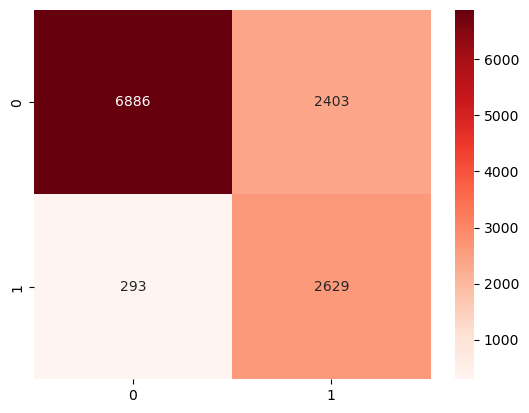

In [130]:
sns.heatmap(confusion_matrix(y_test, y_pred_class_test), annot = True, cmap = plt.cm.Reds, fmt='.0f') # matriz de confusión
plt.show()

In [131]:
print(f"Precision: {round(precision_score(y_test, y_pred_class_test), 4)}")
print(f"Recall: {round(recall_score(y_test, y_pred_class_test), 4)}")
print(f"f1-score: {round(f1_score(y_test, y_pred_class_test), 4)}")

Precision: 0.5225
Recall: 0.8997
f1-score: 0.6611


## Guardar los modelos y el proceso

In [ ]:
import joblib

joblib.dump(norm, '../model/normalization.joblib')
joblib.dump(model, '../model/nn_model.joblib')

['../model/nn_model.joblib']